# Import the necessaries libraries

In [71]:
import warnings

warnings.filterwarnings('ignore')    # ignore all warnings

In [72]:
!pip install contractions
!pip install symspellpy

In [73]:
import re
import os
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import sklearn
from bs4 import BeautifulSoup
from sklearn.metrics import f1_score
import tensorflow_hub as hub
import plotly.express as px
import contractions
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.data import Dataset
import tensorflow.keras as keras
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
from wordcloud import WordCloud
import pkg_resources
from symspellpy import SymSpell, Verbosity


plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')  # set the style of charts

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt


In [74]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_data.sample(5)

,id,keyword,location,text,target
1491,2149,catastrophe,Portugal,Alaska's #Wolves face catastrophe Denali Wolve...,0
5125,7310,nuclear%20reactor,Pluto,'Nuclear reactor is like a woman. You just hav...,0
6438,9211,suicide%20bombing,NaN,Remembering Rebecca Roga 40 of the Philippines...,1
7400,10588,wounded,North Cack/919,I also loved 'Bury my heart at wounded knee' t...,0
3181,4567,emergency%20plan,Surrey & Manchester,NHS England announces new plan to meet emergen...,0


In [75]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [76]:
train_data.keyword = train_data.keyword.fillna('')
train_data.text = (train_data.keyword + " " + train_data.text).str.lower()
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
train_data.at[train_data['id'].isin(ids_with_target_error),'target'] = 0
train_data.drop(columns=['keyword', 'id', 'location'], inplace=True)

# Data visualization

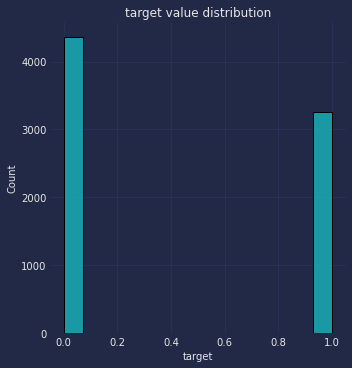

In [77]:
sns.displot(train_data.target).set(title='target value distribution');

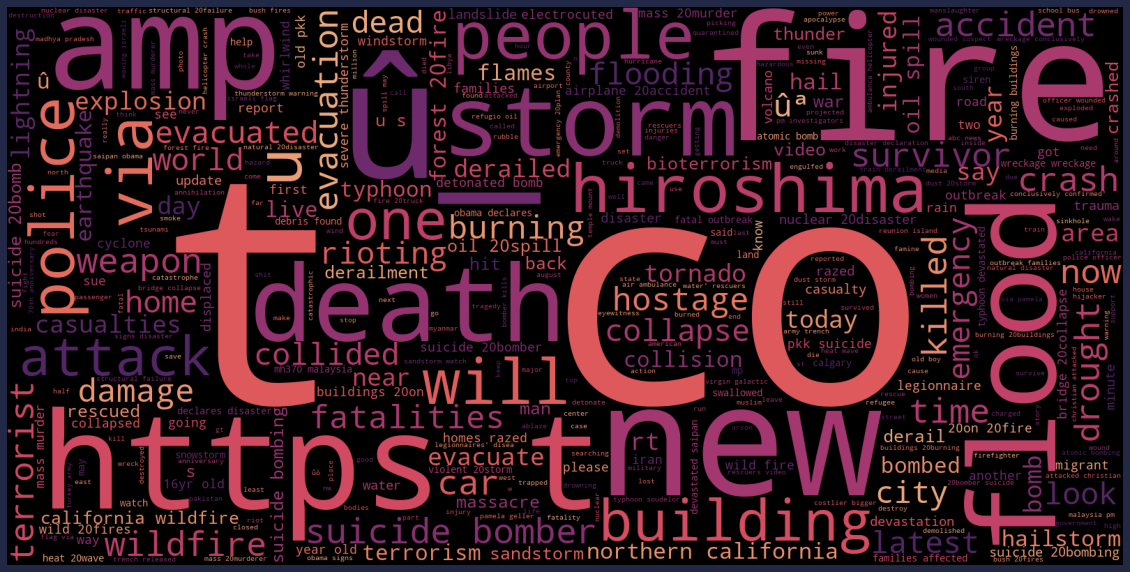

In [78]:
plt.figure(figsize=(20, 20))
Word_Cloud = WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color='black', colormap='flare')\
                      .generate(' '.join(train_data.loc[train_data.target == 1].text))
plt.imshow(Word_Cloud)
plt.axis('off')
plt.show()

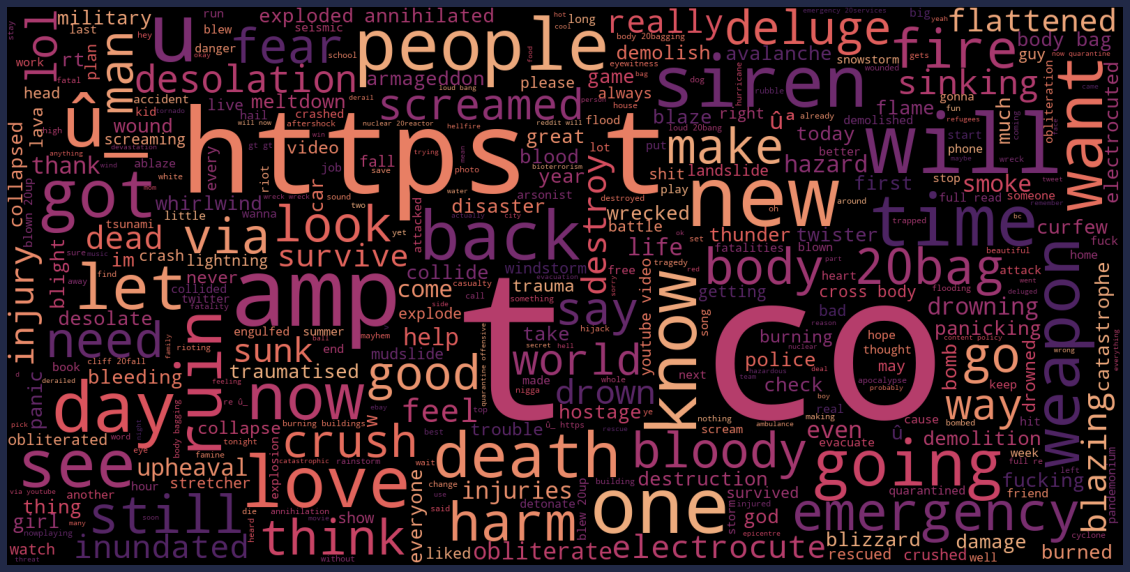

In [79]:
plt.figure(figsize=(20, 20))
Word_Cloud = WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color='black', colormap='flare')\
                      .generate(' '.join(train_data.loc[train_data.target == 0].text))
plt.imshow(Word_Cloud)
plt.axis('off')
plt.show()

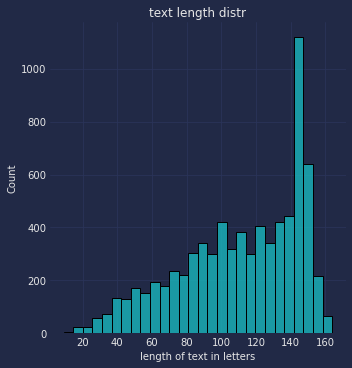

In [80]:
sns.displot(train_data.text.map(len)).set(xlabel='length of text in letters', title='text length distr');

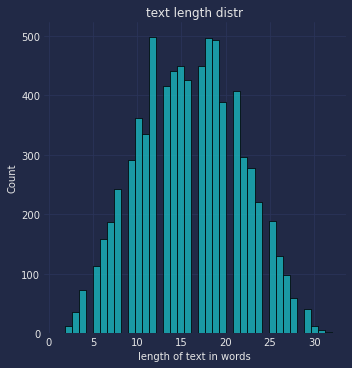

In [81]:
sns.displot(train_data.text.map(lambda text: len(text.split()))).set(xlabel='length of text in words', title='text length distr');

# Data preprocessing

There are many contractions of words used in informal communication such as can't: can not, they've: they have or even modern contractions such as sux: sucks. There is a python package to expand such contractions.



In [82]:
def remove_html(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    return text

def remove_urls(text):
    pattern = re.compile(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?')
    text = re.sub(pattern, "", text)
    return text

def remove_contractions(text):
    return contractions.fix(text)

def remove_emails(text):
    pattern = re.compile(r"[\w\.-]+@[\w\.-]+\.\w+")
    text = re.sub(pattern, "", text)
    return text

def remove_mentions(text):
    pattern = re.compile(r"@\w+")
    text = re.sub(pattern, "", text)
    return text

def remove_unicode_chars(text):
    text = text.encode("ascii", "ignore").decode()
    return text

def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text

def preprocess_text(text):
    text = remove_html(remove_urls(remove_contractions(text)))
    text = remove_mentions(remove_unicode_chars(remove_punctuations(text)))
    return text

In [83]:
train_data.text = train_data.text.apply(preprocess_text)
train_data.sample(5)

,text,target
6294,stretcher coach keith44 hannomottola trpres...,0
6326,structural 20failure 1 investigators say a v...,1
5385,panic dream magic the linden method lite ve...,0
5790,rioting bbcnews the ass of british insurers ...,1
3823,first 20responders us wants future first respo...,0


As you can see, the text in 'text' column became more cleaner.

There are large number of abbreviations and acronyms in the text. These abbreviations can contain meaningful information for the classification task and might get removed or destorted during other preprocessing steps and hence they need to be expanded earlier in the preprocessing. @gunesevitan has given many of these abbreviations in his notebook

In [84]:
def remove_abbreviations(text):
    text = re.sub(r"mh370", "missing malaysia airlines flight", text)
    text = re.sub(r"okwx", "oklahoma city weather", text)
    text = re.sub(r"arwx", "arkansas weather", text)    
    text = re.sub(r"gawx", "georgia weather", text)  
    text = re.sub(r"scwx", "south carolina weather", text)  
    text = re.sub(r"cawx", "california weather", text)
    text = re.sub(r"tnwx", "tennessee weather", text)
    text = re.sub(r"azwx", "arizona weather", text)  
    text = re.sub(r"alwx", "alabama Weather", text)
    text = re.sub(r"wordpressdotcom", "wordpress", text)    
    text = re.sub(r"usnwsgov", "united states national weather service", text)
    text = re.sub(r"suruc", "sanliurfa", text)
    return text

train_data.text = train_data.text.apply(remove_abbreviations)

Stopwords removal is one of the fundamental preprocessing operations in many NLP tasks. I sometimes remove stopwords before removing punctuations as many stopwords contain apostrophe. However, most of these stopwords are expanded during contraction expansion process above.

In [85]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in stop_words])

Lemmatization is the grouping together of different forms of the same word. In search queries, lemmatization allows end users to query any version of a base word and get relevant results.

In [86]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text

train_data.text = train_data.text.apply(lemmatize_text)

Spelling Correction
Spelling correction can help in the NLP task of tweet classification in the considered example because the tweets are particularly succeptible to incorrect spellings of words, either deliberate or otherwise. There are fie woptions such as spell checker from TextBlob and Symspellpy (Python port of SymSpell). 

In [87]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def correct_spelling_symspell(text):
    words = [
        sym_spell.lookup(
            word, 
            Verbosity.CLOSEST, 
            max_edit_distance=2,
            include_unknown=True
            )[0].term 
        for word in text.split()] 
    text = " ".join(words)
    return text

In [88]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [89]:
def convert_abbrev_in_text(text):
    def convert_abbrev(word):
        return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [90]:
train_data.text = train_data.text.apply(correct_spelling_symspell)
train_data.text = train_data.text.apply(remove_stopwords)
train_data.text = train_data.text.apply(convert_abbrev_in_text)
train_data.sample(10)

,text,target
270,annihilation national park service tonto natio...,0
685,blazing danryckert drewscanlon blazing game be...,0
381,arson spokane authority say struggling solve a...,1
3559,famine reuters russian food crematorium provok...,1
3031,earthquake put right person block shell sense ...,0
6261,storm storm came fuck cool,1
3139,emergency god forbid anyone family know answer...,0
3466,exploded okgooner yamaha great song spent year...,0
4429,hostage susanj357 manic allinwithchris like wa...,0
4763,lightning dry thunderstorm lightning possible ...,1


And let's define function that combine all previous preprocessing techniques in one function. This function will be used for test data.

In [91]:
def data_preprocess_pipeline(text):
    text = preprocess_text(text)
    text = correct_spelling_symspell(lemmatize_text(remove_abbreviations(text)))
    return remove_stopwords(convert_abbrev_in_text(text))

# Data visualization after cleaning

Let's first visualize most common words in text with True label(disaster tweet).

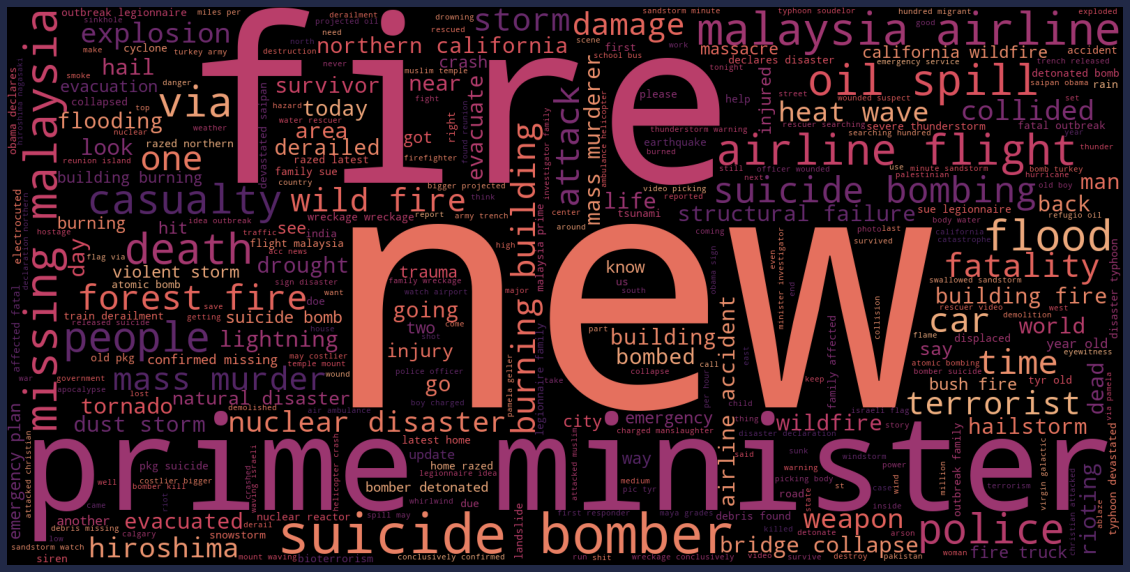

In [92]:
plt.figure(figsize=(20, 20))
Word_Cloud = WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color='black', colormap='flare')\
                      .generate(' '.join(train_data.loc[train_data.target == 1].text))
plt.imshow(Word_Cloud)
plt.axis('off')
plt.show()

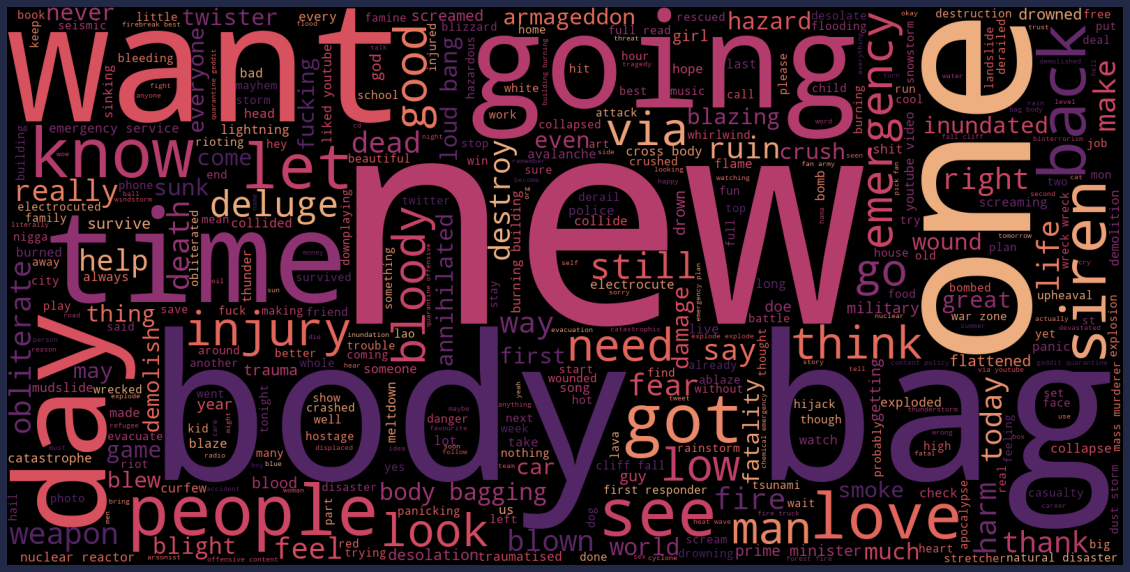

In [93]:
plt.figure(figsize=(20, 20))
Word_Cloud = WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color='black', colormap='flare')\
                      .generate(' '.join(train_data.loc[train_data.target == 0].text))
plt.imshow(Word_Cloud)
plt.axis('off')
plt.show()

# Model

In [94]:
!pip install bert-tensorflow
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

# fixes issue

['preserve_unused_tokens=False']

In [95]:
from bert.tokenization import FullTokenizer

In [96]:
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_data.keyword = test_data.keyword.fillna('')
test_data.text += test_data.keyword + ' '
test_data.drop(columns=['id', 'keyword', 'location'], inplace=True)
test_data.text = test_data.text.apply(data_preprocess_pipeline)

In [97]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [98]:
def build_model(bert_layer, max_len=512):
    input_word_ids = keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = keras.layers.Dense(1, activation='sigmoid')(clf_output)

    model = keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(keras.optimizers.Adam(lr=5.95e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

Download bert model from tf_hub. You can search another models by this [link](http://)

In [99]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [100]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

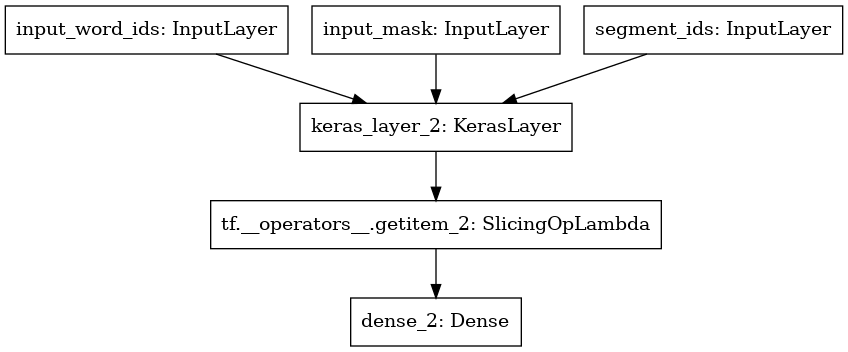

In [101]:
model = build_model(bert_layer, max_len=160)
keras.utils.plot_model(model)

In [102]:
def create_corpus_new(df):
    corpus=[]
    for tweet in df.text:
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus   

corpus = create_corpus_new(train_data)

In [103]:
embedding_dict = {}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
f.close()

In [104]:
from sklearn.model_selection import train_test_split

text_train, text_val, target_train, target_val = train_test_split(train_data.text, train_data.target, train_size=.95, stratify=train_data.target)

train_input = bert_encode(text_train.values, tokenizer, max_len=160)
val_input = bert_encode(text_val.values, tokenizer, max_len=160)

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)
epoch_num = 3

train_history = model.fit(
    train_input, target_train,
    epochs = epoch_num, 
    callbacks=[checkpoint],
    batch_size = 1,
    validation_data = (val_input, target_val)
)

Epoch 1/2
1832/7232 [======>.......................] - ETA: 9:42 - loss: 0.1056 - accuracy: 0.9558

In [111]:
test_input = bert_encode(test_data.text.values, tokenizer, max_len=160)
best_model = keras.models.load_model('/kaggle/working/model_BERT.h5', custom_objects={'KerasLayer': hub.KerasLayer})
preds = best_model.predict(test_input)

In [116]:
ssub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
ssub.target = (preds > .5).astype(int)
ssub.to_csv('submission.csv', index=False)